# Building an RNN from Scratch

## Introduction: Why Are We Doing This?
Sure, we could just `import transformers` and call it a day. But where's the fun in that? Besides, understanding RNNs is like understanding your grandparents' stories - they may seem outdated, but there's wisdom in there somewhere.

## What We're Building
We're implementing a vanilla RNN completely from scratch, armed with nothing but:
- NumPy 
- Basic calculus 
- Unwavering optimism (crucial for debugging backprop)

Our mission? Teaching a neural network to figure out parts of speech.

## The Game Plan
1. Build an RNN cell (the LEGO brick of sequence processing)
2. Stack them together (the LEGO Death Star of NLP)
3. Make it learn through backpropagation (the "please work" phase)
4. Apply it to POS tagging (because someone has to know what adjectives are)

In [1]:
import numpy as np
from scipy.special import softmax

# RNN Structure
The recurrent neural network (RNN) processes a sequence of inputs $x = (x^{<1>}, x^{<2>}, ..., x^{<T_x>})$ using a single RNN cell. 
The RNN cell takes as input the current input $x^{<t>}$ and the previous hidden state $a^{<t-1>}$, 
and outputs the current hidden state $a^{<t>}$ and prediction $y^{<t>}$.

The RNN cell is defined as:
$$a^{<t>} = \tanh(W_{aa} a^{<t-1>} + W_{ax} x^{<t>} + b_a)$$
$$\hat{y}^{<t>} = softmax(W_{ya}a^{<t>} + b_y)$$

![local image](./Images/RNN.png)


## The Mathematics Behind RNNs
For each time step t, an RNN processes:
- Input: $x^{<t>}$ (current word embedding)
- Previous hidden state: $a^{<t-1>}$ (carrying context)
- Target: $y^{<t>}$ (true POS tag)

The forward pass comprises two key equations:
1. Hidden state update:
   $a^{<t>} = \tanh(W_{ax}x^{<t>} + W_{aa}a^{<t-1>} + b_a)$
   where:
   - $W_{ax}$: input-to-hidden weights
   - $W_{aa}$: hidden-to-hidden weights
   - $b_a$: hidden bias

2. Output prediction:
   $\hat{y}^{<t>} = \text{softmax}(W_{ya}a^{<t>} + b_y)$
   where:
   - $W_{ya}$: hidden-to-output weights
   - $b_y$: output bias


The implementation of a signle RNN cell is as follows:


In [2]:
def rnn_cell_forward(xt, yt, a_prev, parameters):
    """
    Implements a single forward step of the RNN-cell.

    Arguments:
    xt -- input data at timestep "t", numpy array of shape (n_x, b) 
    yt -- true values at timestep "t", numpy array of shape (n_y, b)
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, b)
    parameters -- python dictionary containing:
                 Wax -- Input-to-hidden weights (n_a, n_x)
                 Waa -- Hidden-to-hidden weights (n_a, n_a)
                 Wya -- Hidden-to-output weights (n_y, n_a)
                 ba -- Hidden bias (n_a, 1)
                 by -- Output bias (n_y, 1)

    Returns:
    a_next -- next hidden state, shape (n_a, b)
    yt_pred -- prediction at timestep "t", shape (n_y, b)
    cache -- tuple for backward pass (a_next, a_prev, xt, yt, parameters, yt_pred)
    """
    # Unpack parameters
    Wax = parameters['Wax']
    Waa = parameters['Waa']
    Wya = parameters['Wya']
    ba = parameters['ba']
    by = parameters['by']

    # Compute next hidden state using tanh activation
    a_next = np.tanh(np.dot(Wax, xt) + np.dot(Waa, a_prev) + ba)

    # Compute prediction using softmax activation
    yt_pred = softmax(np.dot(Wya, a_next) + by)

    # Store values needed for backward pass
    cache = (a_next, a_prev, xt, yt, parameters, yt_pred)

    return a_next, yt_pred, cache


# Forward pass through time

## Full Sequence Forward Propagation
After implementing a single RNN cell, we need to process entire sequences. For POS tagging, this means handling complete sentences where each word (token) is processed sequentially while maintaining contextual information through hidden states.

### Mathematical Formulation
For a sequence of length T, we iteratively apply:
1. Hidden state propagation:
   $a^{<t>} = \tanh(W_{ax}x^{<t>} + W_{aa}a^{<t-1>} + b_a)$
   for t = 1, ..., T

2. Predictions at each step:
   $\hat{y}^{<t>} = \text{softmax}(W_{ya}a^{<t>} + b_y)$

### Dimensions and Notation
- **Batch processing**: b sequences processed simultaneously
- **Input dimensions**: (n_x, b, T_x) where:
  - n_x: embedding dimension
  - b: batch size
  - T_x: sequence length
- **Hidden state**: (n_a, b) per time step
- **Output**: (n_y, b) predictions per time step

### Implementation
The following function implements forward propagation through time, maintaining caches for backpropagation:

In [44]:
def rnn_forward(x, y, a0, parameters):
    """
    Implement forward propagation for a RNN over an entire sequence.

    Arguments:
    x -- Input data, numpy array of shape (n_x, b, T_x)
    y -- True values, numpy array of shape (n_y, b, T_x)
    a0 -- Initial hidden state, numpy array of shape (n_a, b)
    parameters -- python dictionary containing:
                 Wax -- Input-to-hidden weights (n_a, n_x)
                 Waa -- Hidden-to-hidden weights (n_a, n_a)
                 Wya -- Hidden-to-output weights (n_y, n_a)
                 ba -- Hidden bias (n_a, 1)
                 by -- Output bias (n_y, 1)

    Returns:
    a -- Hidden states for all timesteps, shape (n_a, b, T_x)
    y_pred -- Predictions for all timesteps, shape (n_y, b, T_x)
    caches -- List of caches containing for each timestep:
              (a_next, a_prev, xt, yt, parameters, yt_pred)
    """
    # Get dimensions from input shapes
    n_x, b, T_x = x.shape
    n_y, n_a = parameters["Wya"].shape
    
    # Initialize outputs and hidden states
    a = np.zeros((n_a, b, T_x))
    y_pred = np.zeros((n_y, b, T_x))
    a_next = a0
    
    # Store caches for backward pass
    caches = []
    
    # Forward propagation over time steps
    for t in range(T_x):
        # Get current timestep input and true value
        xt = x[:,:,t]
        yt = y[:,:,t]
        
        # Forward step for current timestep
        a_next, yt_pred, cache = rnn_cell_forward(xt, yt, a_next, parameters)
        
        # Store current hidden state and prediction
        a[:,:,t] = a_next
        y_pred[:,:,t] = yt_pred
        
        # Store cache for backward pass
        caches.append(cache)
    
    return a, y_pred, caches

# Back Propagation

## Backpropagation Through a Single RNN Cell
The backward pass computes gradients for a single timestep, which will be used to update the network parameters. This involves applying the chain rule through both the output and hidden state computations.

### Gradient Flow
For a single RNN cell, we need to compute gradients through:
1. Output layer (cross-entropy loss):
   - $\frac{\partial \mathcal{L}}{\partial \hat{y}^{<t>}} = \hat{y}^{<t>} - y^{<t>}$ (for cross-entropy)
   - $\frac{\partial \mathcal{L}}{\partial W_{ya}} = \frac{\partial \mathcal{L}}{\partial \hat{y}^{<t>}} (a^{<t>})^T$

2. Hidden state:
   - $\frac{\partial \mathcal{L}}{\partial a^{<t>}} = W_{ya}^T\frac{\partial \mathcal{L}}{\partial \hat{y}^{<t>}} + \frac{\partial \mathcal{L}}{\partial a^{<t+1>}}$
   - $\frac{\partial \mathcal{L}}{\partial z^{<t>}} = \frac{\partial \mathcal{L}}{\partial a^{<t>}} \odot (1-(a^{<t>})^2)$ (tanh derivative)

3. Input and previous state:
   - $\frac{\partial \mathcal{L}}{\partial W_{ax}} = \frac{\partial \mathcal{L}}{\partial z^{<t>}}(x^{<t>})^T$
   - $\frac{\partial \mathcal{L}}{\partial W_{aa}} = \frac{\partial \mathcal{L}}{\partial z^{<t>}}(a^{<t-1>})^T$



![local image](./Images/Back_Propagation.png)



### Implementation
The following function computes all necessary gradients for a single timestep:

In [4]:
def rnn_cell_backward(da_next, cache):
    """
    Implements the backward pass for a single RNN cell timestep.

    Arguments:
    da_next -- Gradient of loss with respect to next hidden state, shape (n_a, b)
    cache -- tuple containing:
        a_next -- Next hidden state
        a_prev -- Previous hidden state
        xt -- Input at current timestep
        y_target -- True values
        parameters -- Dictionary of weights and biases
        y_pred -- Predictions at current timestep

    Returns:
    gradients -- Dictionary containing:
        dx -- Gradients w.r.t input data (n_x, b)
        da_prev -- Gradients w.r.t previous hidden state (n_a, b)
        dWax -- Gradients w.r.t input-to-hidden weights (n_a, n_x)
        dWaa -- Gradients w.r.t hidden-to-hidden weights (n_a, n_a)
        dWya -- Gradients w.r.t hidden-to-output weights (n_y, n_a)
        dba -- Gradients w.r.t hidden bias (n_a, 1)
        dby -- Gradients w.r.t output bias (n_y, 1)
    """
    # Retrieve values from cache
    a_next, a_prev, xt, y_target, parameters, y_pred = cache
    
    # Retrieve parameters
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    
    # Output layer gradients
    dy = y_pred - y_target                  # Cross-entropy loss derivative
    dWya = np.dot(dy, a_next.T)            # Hidden-to-output weights gradient
    dby = np.sum(dy, axis=1, keepdims=True) # Output bias gradient
    
    # Hidden layer gradients
    da = np.dot(Wya.T, dy) + da_next       # Add gradient from next cell
    dtanh = (1 - a_next**2) * da           # Tanh derivative
    
    # Weight and bias gradients
    dWax = np.dot(dtanh, xt.T)             # Input-to-hidden weights gradient
    dWaa = np.dot(dtanh, a_prev.T)         # Hidden-to-hidden weights gradient
    dba = np.sum(dtanh, axis=1, keepdims=True)  # Hidden bias gradient
    
    # Input gradients
    dx = np.dot(Wax.T, dtanh)              # Input gradient
    da_prev = np.dot(Waa.T, dtanh)         # Previous hidden state gradient
    
    # Store gradients
    gradients = {
        'dx': dx,
        'da_prev': da_prev, 
        'dWax': dWax,
        'dWaa': dWaa,
        'dWya': dWya,
        'dba': dba,
        'dby': dby
    }
    
    return gradients

## Backpropagation Through Time (BPTT)
Backpropagation through time extends the backward pass to entire sequences, with a crucial characteristic: weight sharing across time steps. The same weights ($W_{ax}$, $W_{aa}$, $W_{ya}$) are used at each time step, which leads to an important implementation detail: gradients must be accumulated across all time steps.

### Weight Sharing and Gradient Accumulation
For each weight matrix, the total gradient is the sum of gradients from all time steps:

$\frac{\partial \mathcal{L}}{\partial W_{ax}} = \sum_{t=1}^T \frac{\partial \mathcal{L}_t}{\partial W_{ax}}$

$\frac{\partial \mathcal{L}}{\partial W_{aa}} = \sum_{t=1}^T \frac{\partial \mathcal{L}_t}{\partial W_{aa}}$

$\frac{\partial \mathcal{L}}{\partial W_{ya}} = \sum_{t=1}^T \frac{\partial \mathcal{L}_t}{\partial W_{ya}}$

### Gradient Flow Through Time
The backward pass processes the sequence in reverse order because:
1. Later time steps affect earlier ones through hidden states
2. Gradient at time t depends on future time steps t+1, t+2, ..., T
3. Initial hidden state (a0) gradient accumulates from all time steps

### Implementation
The following function implements BPTT, accumulating gradients across the sequence:

In [5]:
def rnn_backward(caches):
    """
    Implement backward pass for a RNN over an entire sequence of input data.

    Arguments:
    caches -- list containing tuples for each timestep t:
              (a_next, a_prev, xt, yt, parameters, y_pred)

    Returns:
    gradients -- Dictionary containing:
                dx_total -- Gradient w.r.t. input data (n_x, b, T_x)
                da0 -- Gradient w.r.t. initial hidden state (n_a, b)
                dWax_total -- Gradient w.r.t. input weights (n_a, n_x)
                dWaa_total -- Gradient w.r.t. hidden weights (n_a, n_a)
                dWya_total -- Gradient w.r.t. output weights (n_y, n_a)
                dba_total -- Gradient w.r.t. hidden bias (n_a, 1)
                dby_total -- Gradient w.r.t. output bias (n_y, 1)
    """
    # Retrieve dimensions from first cache
    (a1, a0, x1, y1, parameters, _) = caches[0]
    n_a, b = a0.shape
    n_x, _ = x1.shape
    n_y, _ = y1.shape
    T_x = len(caches)
    
    # Initialize gradients
    dx = np.zeros((n_x, b, T_x))
    dWax = np.zeros((n_a, n_x))
    dWaa = np.zeros((n_a, n_a))
    dWya = np.zeros((n_y, n_a))
    dba = np.zeros((n_a, 1))
    dby = np.zeros((n_y, 1))
    da0 = np.zeros((n_a, b))
    
    # Initialize gradient for next hidden state
    da_next = np.zeros((n_a, b))
    
    # Backpropagate through time
    for t in reversed(range(T_x)):
        # Compute gradients at current timestep
        gradients = rnn_cell_backward(da_next, caches[t])
        
        # Extract gradients for current timestep
        dx_t = gradients['dx']
        da_next = gradients['da_prev']
        
        # Store dx for current timestep
        dx[:,:,t] = dx_t
        
        # Accumulate weight gradients
        dWax += gradients['dWax']
        dWaa += gradients['dWaa']
        dWya += gradients['dWya']
        dba += gradients['dba']
        dby += gradients['dby']
    
    # da0 is the gradient w.r.t. the initial hidden state
    da0 = da_next
    
    # Store all gradients in dictionary
    gradients = {
        'dx_total': dx,
        'da0': da0,
        'dWax_total': dWax,
        'dWaa_total': dWaa,
        'dWya_total': dWya,
        'dba_total': dba,
        'dby_total': dby
    }
    
    return gradients

## Reality Check! 🤔

Let's make sure our mathematical masterpiece is functioning.

### What We're Testing:
- Forward pass
- Backward pass (aka "The Ghost of Gradients Past")
- Shapes
- Probabilities (making sure they sum to 1)

In [6]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Define dimensions
n_x = 10      # embedding size
n_a = 16      # hidden state size
n_y = 5       # vocabulary size
b = 4         # batch size
T_x = 20      # sequence length

# Create dummy data
x = np.random.randn(n_x, b, T_x)  # Input sequences
y = np.random.randint(0, n_y, size=(n_y, b, T_x))  # One-hot encoded targets
y = (y == np.arange(n_y)[:, None, None]).astype(int)  # Convert to one-hot

# Initialize parameters
parameters = {
    'Wax': np.random.randn(n_a, n_x) * 0.01,   # Input weights
    'Waa': np.random.randn(n_a, n_a) * 0.01,   # Hidden weights
    'Wya': np.random.randn(n_y, n_a) * 0.01,   # Output weights
    'ba': np.zeros((n_a, 1)),                   # Hidden bias
    'by': np.zeros((n_y, 1))                    # Output bias
}

# Initialize hidden state
a0 = np.zeros((n_a, b))

print("Shapes:")
print(f"Input (x): {x.shape}")
print(f"Targets (y): {y.shape}")
print(f"Initial hidden state (a0): {a0.shape}\n")

# Forward pass
print("Forward pass:")
print("-" * 50)

# First, show single cell forward
print("Single cell (t=0):")
xt = x[:,:,0]
yt = y[:,:,0]
a_next, yt_pred, cache = rnn_cell_forward(xt, yt, a0, parameters)
print(f"Input timestep (xt): {xt.shape}")
print(f"Hidden state (a_next): {a_next.shape}")
print(f"Prediction (yt_pred): {yt_pred.shape}")
print(f"Prediction sum (should be 1): {yt_pred.sum(axis=0)[:3]}\n")  # Show first 3 samples

# Then, full sequence forward
print("Full sequence:")
a, y_pred, caches = rnn_forward(x, y, a0, parameters)
print(f"All hidden states (a): {a.shape}")
print(f"All predictions (y_pred): {y_pred.shape}")
print(f"Number of cached timesteps: {len(caches)}\n")

# Backward pass
print("Backward pass:")
print("-" * 50)

# First, show single cell backward for last timestep
print("Single cell backward (last timestep):")
da_next = np.random.randn(n_a, b) * 0.01
gradients = rnn_cell_backward(da_next, caches[-1])
for key, value in gradients.items():
    print(f"{key}: {value.shape}")
print()

# Then, full sequence backward
print("Full sequence backward:")
gradients = rnn_backward(caches)
for key, value in gradients.items():
    print(f"{key}: {value.shape}")

# Show some actual values
print("\nSample values:")
print("-" * 50)
print(f"First prediction probabilities (timestep 0, first sample):\n{y_pred[:,0,0]}")
print(f"\nFirst target (timestep 0, first sample):\n{y[:,0,0]}")

Shapes:
Input (x): (10, 4, 20)
Targets (y): (5, 4, 20)
Initial hidden state (a0): (16, 4)

Forward pass:
--------------------------------------------------
Single cell (t=0):
Input timestep (xt): (10, 4)
Hidden state (a_next): (16, 4)
Prediction (yt_pred): (5, 4)
Prediction sum (should be 1): [0.24991465 0.25018465 0.24993291]

Full sequence:
All hidden states (a): (16, 4, 20)
All predictions (y_pred): (5, 4, 20)
Number of cached timesteps: 20

Backward pass:
--------------------------------------------------
Single cell backward (last timestep):
dx: (10, 4)
da_prev: (16, 4)
dWax: (16, 10)
dWaa: (16, 16)
dWya: (5, 16)
dba: (16, 1)
dby: (5, 1)

Full sequence backward:
dx_total: (10, 4, 20)
da0: (16, 4)
dWax_total: (16, 10)
dWaa_total: (16, 16)
dWya_total: (5, 16)
dba_total: (16, 1)
dby_total: (5, 1)

Sample values:
--------------------------------------------------
First prediction probabilities (timestep 0, first sample):
[0.05001189 0.04996267 0.04996702 0.04999154 0.04998153]

First 

# Application: Part-of-Speech Tagging

Part-of-Speech (POS) tagging is a fundamental task in Natural Language Processing where we assign grammatical tags to words based on their context. This serves as an excellent application for our RNN implementation as it requires:
1. Sequential processing of words
2. Contextual understanding
3. Multi-class classification

### Data Sources
We utilize three standard corpora from NLTK:
- Penn Treebank: Wall Street Journal text with manual POS annotations
- Brown Corpus: American English text across multiple genres
- CoNLL-2000: Text annotated for chunking tasks

These corpora use the Universal POS tagset, providing a standardized set of grammatical categories across different texts.

### Data Preparation
The implementation requires:
1. Converting text to numerical representations
2. Creating consistent sequence lengths
3. Generating appropriate input-output pairs for training

In [7]:
import nltk

# Download required NLTK datasets if not already present
nltk.download('treebank')    # Penn Treebank corpus
nltk.download('brown')       # Brown corpus
nltk.download('conll2000')   # CoNLL-2000 chunking corpus
nltk.download('universal_tagset')  # Universal POS tag set

from nltk.corpus import treebank, brown, conll2000

# Load tagged sentences from different corpora using universal tagset
treebank_corpus = treebank.tagged_sents(tagset = 'universal')
brown_corpus = brown.tagged_sents(tagset = 'universal')
conll_corpus = conll2000.tagged_sents(tagset = 'universal')

# Combine all corpora into one dataset
tagged_sentences = treebank_corpus + brown_corpus + conll_corpus

[nltk_data] Downloading package treebank to /home/sorous/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package brown to /home/sorous/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package conll2000 to /home/sorous/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/sorous/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


## Data Visualization and Format

To better understand our POS tagging task, let's examine a sample sentence from our dataset. The data is structured as pairs of words and their corresponding POS tags.


In [45]:
# Display an example sentence with its POS tags
example_sentence = tagged_sentences[1]
print("Example tagged sentence structure:\n")

print(f"Sample data: {example_sentence}\n")
print('-' * 25, 'Word-tag pairs', '-' * 25)
for word, tag in example_sentence:
    print(f"{word:15} -> {tag}")

print('-' * 25, 'Or Better Shown', '-' * 25)

# Separate words and tags
words, tags = zip(*example_sentence)

# Find maximum word length for padding
max_len = max(len(word) for word in words)

# Create aligned strings
aligned_words = ' '.join(word.ljust(max_len) for word in words)
aligned_tags  = ' '.join(tag.ljust(max_len) for tag in tags)

print(f"Sentence: {aligned_words}")
print(f"Tags:     {aligned_tags}")

Example tagged sentence structure:

Sample data: [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]

------------------------- Word-tag pairs -------------------------
Mr.             -> NOUN
Vinken          -> NOUN
is              -> VERB
chairman        -> NOUN
of              -> ADP
Elsevier        -> NOUN
N.V.            -> NOUN
,               -> .
the             -> DET
Dutch           -> NOUN
publishing      -> VERB
group           -> NOUN
.               -> .
------------------------- Or Better Shown -------------------------
Sentence: Mr.        Vinken     is         chairman   of         Elsevier   N.V.       ,          the        Dutch      publishing group      .         
Tags:     NOUN       NOUN       VERB       NOUN       ADP        NOUN       NOUN       .          DET        NOUN       VERB 

## Data Preprocessing: Creating Word and Tag Sequences

After examining the data format, we need to preprocess our tagged sentences into a format suitable for the RNN. This involves:

1. Separating words and tags into distinct sequences
2. Converting all words to lowercase for consistency
3. Maintaining parallel sequences where:
   - X[i] contains the word sequence for sentence i
   - Y[i] contains the corresponding tag sequence

This step transforms our data from paired word-tag tuples into separate sequences while preserving the alignment between words and their POS tags.


In [9]:
# Separate words and tags into two lists of sequences and gather statistics
X = []  # Will contain sequences of words
Y = []  # Will contain sequences of POS tags

for sentence in tagged_sentences:
    # Split each (word, tag) tuple in the sentence into separate lists
    words, tags = zip(*sentence)
    
    # Convert words to lowercase and update statistics
    words = [word.lower() for word in words]
    
    # Add the sequences to our dataset
    X.append(words)
    Y.append(tags)

## Dataset Statistics 

Let's check a few things,
   - Total number of training sentences
   - Vocabulary size (unique words)
   - Number of distinct POS tags


In [10]:
# Calculate unique words and tags
unique_words = set(word for sentence in X for word in sentence)
unique_tags = set(tag for sentence in Y for tag in sentence)

# Display dataset statistics
print("Dataset Statistics:")
print("-" * 50)
print(f"Total number of sentences: {len(X):,}")
print(f"Vocabulary size: {len(unique_words):,} words")
print(f"Tag set size: {len(unique_tags)} tags")

print("\nUniversal POS Tags:")
for tag in sorted(unique_tags):
    print(f"- {tag}")

Dataset Statistics:
--------------------------------------------------
Total number of sentences: 72,202
Vocabulary size: 59,448 words
Tag set size: 12 tags

Universal POS Tags:
- .
- ADJ
- ADP
- ADV
- CONJ
- DET
- NOUN
- NUM
- PRON
- PRT
- VERB
- X


### Word Embeddings
### Word Embeddings
Rather than training word embeddings from scratch (which would require serious computational resources and a level of patience I haven't unlocked yet), we utilize Word2Vec to generate pre-trained embeddings. These embeddings are frozen during training, meaning:
- We benefit from pre-learned word representations
- Only RNN parameters are updated during training
- Our GPUs thank us for this merciful decision

The trade-off? We sacrifice the ability to fine-tune word representations, but sometimes you have to choose between perfection and getting things done before the heat death of the universe.

Dimensions:
- Embedding size: 100 dimensions
- Maximum sequence length: 100 tokens
- Each word mapped to its corresponding embedding vector

### POS Tag Encoding
Tags are encoded using one-hot vectors, where:
- Each tag maps to a 13-dimensional binary vector
- First position reserved for padding
- Remaining positions correspond to Universal POS tags

In [11]:
from gensim.models import Word2Vec

# Train word embeddings
model = Word2Vec(X, min_count=1, vector_size=100)

# Constants
MAX_SEQ_LEN = 100
EMBEDDING_DIM = 100
NUM_TAGS = 13

# Create embedded word sequences
emb_X = np.zeros((EMBEDDING_DIM, len(X), MAX_SEQ_LEN))
for i, sentence in enumerate(X):
    for j, word in enumerate(sentence[:MAX_SEQ_LEN]):
        emb_X[:,i,j] = model.wv[word]

# Define POS tags and their one-hot encodings
tag_encodings = {
    'PAD':  [1,0,0,0,0,0,0,0,0,0,0,0,0],
    'NOUN': [0,1,0,0,0,0,0,0,0,0,0,0,0],
    '.':    [0,0,1,0,0,0,0,0,0,0,0,0,0],
    'NUM':  [0,0,0,1,0,0,0,0,0,0,0,0,0],
    'ADJ':  [0,0,0,0,1,0,0,0,0,0,0,0,0],
    'VERB': [0,0,0,0,0,1,0,0,0,0,0,0,0],
    'DET':  [0,0,0,0,0,0,1,0,0,0,0,0,0],
    'ADP':  [0,0,0,0,0,0,0,1,0,0,0,0,0],
    'CONJ': [0,0,0,0,0,0,0,0,1,0,0,0,0],
    'X':    [0,0,0,0,0,0,0,0,0,1,0,0,0],
    'PRT':  [0,0,0,0,0,0,0,0,0,0,1,0,0],
    'ADV':  [0,0,0,0,0,0,0,0,0,0,0,1,0],
    'PRON': [0,0,0,0,0,0,0,0,0,0,0,0,1]
}

# Create encoded tag sequences
enc_Y = np.zeros((NUM_TAGS, len(Y), MAX_SEQ_LEN))
for i, sentence in enumerate(Y):
    for j, tag in enumerate(sentence[:MAX_SEQ_LEN]):
        enc_Y[:,i,j] = tag_encodings[tag]


In [12]:
# Verify shapes
print("Data shapes:")
print(f"Word embeddings (emb_X): {emb_X.shape}")
print(f"Tag encodings (enc_Y): {enc_Y.shape}")

Data shapes:
Word embeddings (emb_X): (100, 72202, 100)
Tag encodings (enc_Y): (13, 72202, 100)


In [ ]:
# Normalization of input embeddings
emb_X = (emb_X - emb_X.mean()) / emb_X.std()

## Training the Model: Put It All Together

### Model Configuration
We configure our RNN with:
- 40-dimensional hidden states (n_a)
- 100-dimensional input embeddings (n_x)
- 13-dimensional output for POS tags (n_y)
- Batch size of 1000 sequences
- Initial learning rate of 5e-3 with decay

### Training Process
The training loop implements several crucial components:
1. Forward Propagation:
   - Process batches of embedded sequences
   - Generate POS tag predictions
   - Cache intermediate values for backprop

2. Backward Propagation:
   - Compute gradients through time
   - Clip gradients to prevent explosion (-5 to 5)
   - Accumulate updates for shared parameters

3. Parameter Updates:
   - Apply gradient descent with learning rate decay
   - Monitor gradient norms for stability
   - Track accuracy excluding padding tokens

4. Performance Monitoring:
   - Track accuracy over epochs
   - Monitor gradient magnitudes
   - Implement learning rate scheduling

This training procedure balances computational efficiency with numerical stability through gradient clipping and learning rate adaptation.


In [41]:
# Set random seed for reproducibility
np.random.seed(1)

# Model dimensions
n_a = 40        # hidden state size
n_x = 100       # input size (embedding dimension)
n_y = 13        # output size (number of POS tags)
batch_size = 1000
learning_rate = 5e-3

# Initialize parameters
parameters = {
    "Wax": np.random.randn(n_a, n_x) * 0.02,   # Input weights
    "Waa": np.random.randn(n_a, n_a) * 0.02,   # Hidden weights
    "Wya": np.random.randn(n_y, n_a) * 0.02,   # Output weights
    "ba": np.random.randn(n_a, batch_size) * 0.02,  # Hidden bias
    "by": np.random.randn(n_y, batch_size) * 0.02   # Output bias
}

# Initialize hidden state
a0 = np.random.randn(n_a, batch_size) * 0.02

# Training loop
accuracies = []
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    a, y_pred, caches = rnn_forward(emb_X[:, :batch_size, :], 
                                  enc_Y[:, :batch_size, :], 
                                  a0, 
                                  parameters)
    
    # Backward pass
    gradients = rnn_backward(caches)
    
    # Clip gradients
    for grad_name, grad_value in gradients.items():
        np.clip(grad_value, -5, 5, out=gradients[grad_name])
    
    # Update parameters
    for param_name, param_value in parameters.items():
        grad_name = f"d{param_name}_total"
        parameters[param_name] += -learning_rate * gradients[grad_name]
    
    # Calculate accuracy
    predictions = np.argmax(y_pred, axis=0)
    output = np.zeros_like(y_pred)
    for i in range(batch_size):
        for j in range(y_pred.shape[2]):  # sequence length
            output[predictions[i,j], i, j] = 1
    
    # Calculate accuracy excluding padding tag (index 0)
    correct_predictions = np.multiply(enc_Y[1:, :batch_size, :], output[1:, :, :]).sum()
    total_tags = enc_Y[1:, :batch_size, :].sum()
    accuracy = correct_predictions / total_tags
    
    grad_norm = np.sqrt(sum(np.sum(grad**2) for grad in gradients.values()))

    # Try with learning rate scheduling
    if learning_rate > 1e-3:
        learning_rate *= 0.99  # Decay over time

    accuracies.append(accuracy)
    print(f"Epoch {epoch:3d} \t Accuracy: {accuracy:.4f} \t Learning Rate: {learning_rate:.5f} \t Grad Norm: {grad_norm:.2f}")
    

Epoch   0 	 Accuracy: 0.1249 	 Learning Rate: 0.00495 	 Grad Norm: 380.95
Epoch   1 	 Accuracy: 0.3082 	 Learning Rate: 0.00490 	 Grad Norm: 387.10
Epoch   2 	 Accuracy: 0.4763 	 Learning Rate: 0.00485 	 Grad Norm: 381.22
Epoch   3 	 Accuracy: 0.4237 	 Learning Rate: 0.00480 	 Grad Norm: 362.53
Epoch   4 	 Accuracy: 0.5689 	 Learning Rate: 0.00475 	 Grad Norm: 335.57
Epoch   5 	 Accuracy: 0.4951 	 Learning Rate: 0.00471 	 Grad Norm: 324.07
Epoch   6 	 Accuracy: 0.6364 	 Learning Rate: 0.00466 	 Grad Norm: 314.77
Epoch   7 	 Accuracy: 0.5331 	 Learning Rate: 0.00461 	 Grad Norm: 304.52
Epoch   8 	 Accuracy: 0.6091 	 Learning Rate: 0.00457 	 Grad Norm: 302.26
Epoch   9 	 Accuracy: 0.6701 	 Learning Rate: 0.00452 	 Grad Norm: 299.37
Epoch  10 	 Accuracy: 0.5714 	 Learning Rate: 0.00448 	 Grad Norm: 299.18
Epoch  11 	 Accuracy: 0.7004 	 Learning Rate: 0.00443 	 Grad Norm: 295.69
Epoch  12 	 Accuracy: 0.6235 	 Learning Rate: 0.00439 	 Grad Norm: 292.63
Epoch  13 	 Accuracy: 0.7143 	 Learnin

## The Moment of Truth: How Did We Do? 📊

Our humble RNN, built with nothing but numpy and determination, managed to achieve:
- ~76% accuracy (not exactly ChatGPT territory, but hey, we'll take it!)
- Stable training 
- Actual learning

Sure, we won't be challenging state-of-the-art models anytime soon, but for a "homemade" RNN:
- No fancy attention mechanisms
- No transformer architecture
- No 175 billion parameters
- Just pure, vanilla RNN goodness

Let's visualize our journey from random guessing to "actually not terrible":

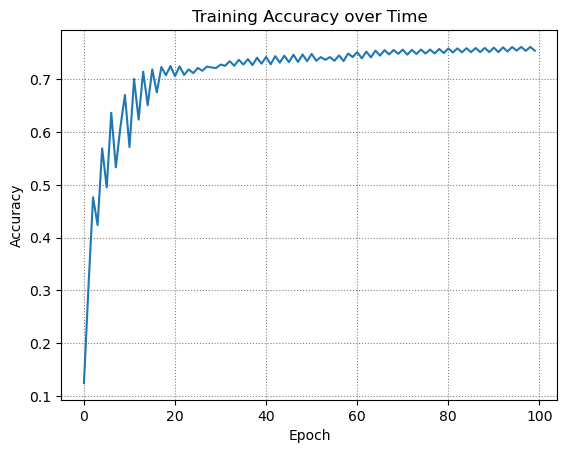

In [42]:
# Plot training progress
import matplotlib.pyplot as plt

plt.plot(accuracies)
plt.title('Training Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(ls = ':', color = 'gray')